# Task 2: Time Series Forecasting Models

**Objective:** Develop, train, and evaluate time series forecasting models to predict Tesla's future stock prices.

We will implement ARIMA/SARIMA and LSTM models and compare their performance.

In [1]:
import sys
import os

# Add the src directory to the path to import modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from data_loader import fetch_data, clean_data, load_data
from models import optimize_arima, train_arima_model, prepare_lstm_data, build_lstm_model, evaluate_model_metrics

%matplotlib inline

## 1. Prepare Data for Modeling

Train size: 2516
Test size: 259


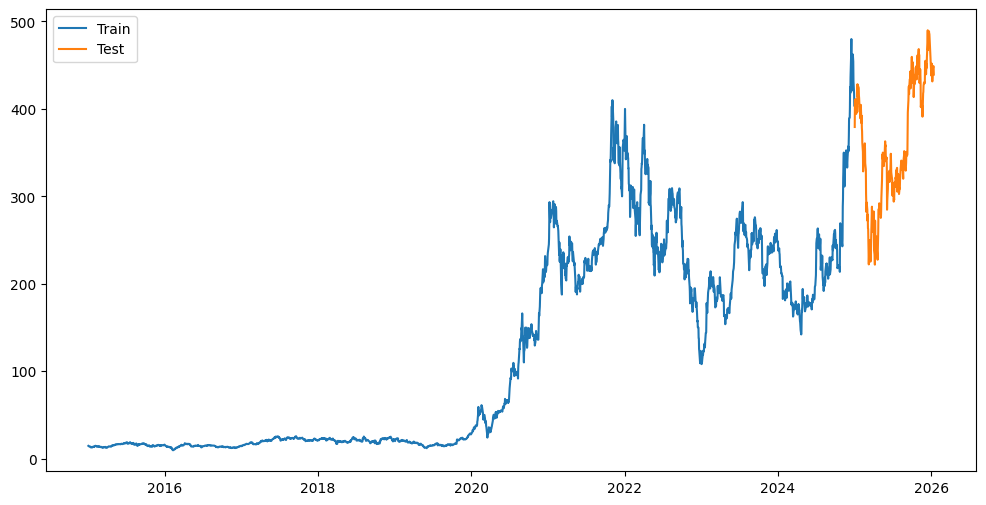

In [2]:
# Fetch TSLA Data
data = load_data()
data = clean_data(data)
tsla_prices = data['TSLA']

# Split Train (2015-2024) and Test (2025-2026)
train_data = tsla_prices[:'2024-12-31']
test_data = tsla_prices['2025-01-01':]

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.legend()
plt.show()

## 2. Implement ARIMA/SARIMA Model

In [3]:
# Find optimal parameters (using a subset for speed if necessary, but full train is better)
print("Finding optimal ARIMA parameters...")
# Note: m=1 for non-seasonal, set seasonal=True and m=5 (weekly) or m=12 (monthly) if seasonality is suspected.
# Here we start with non-seasonal for simplicity, but can enable seasonal.
auto_model = optimize_arima(train_data, seasonal=False)
print(auto_model.summary())

Finding optimal ARIMA parameters...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8183.054
Date:                Sun, 25 Jan 2026   AIC                          16368.109
Time:                        14:51:27   BIC                          16373.939
Sample:                             0   HQIC                         16370.225
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.2337      0.442     88.858      0.000      38.368      40.099
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):             11691.05
Prob(Q):   

Training ARIMA with order (0, 1, 0)...
ARIMA Metrics: {'MAE': 69.4989569233191, 'RMSE': np.float64(82.93461282588196), 'MAPE': np.float64(22.557915255182202)}


c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abenezer\Desktop\KAIM Project\portfolio-optimization\venv9\Lib\site-packages\statsmodels\tsa\base\tsa_m

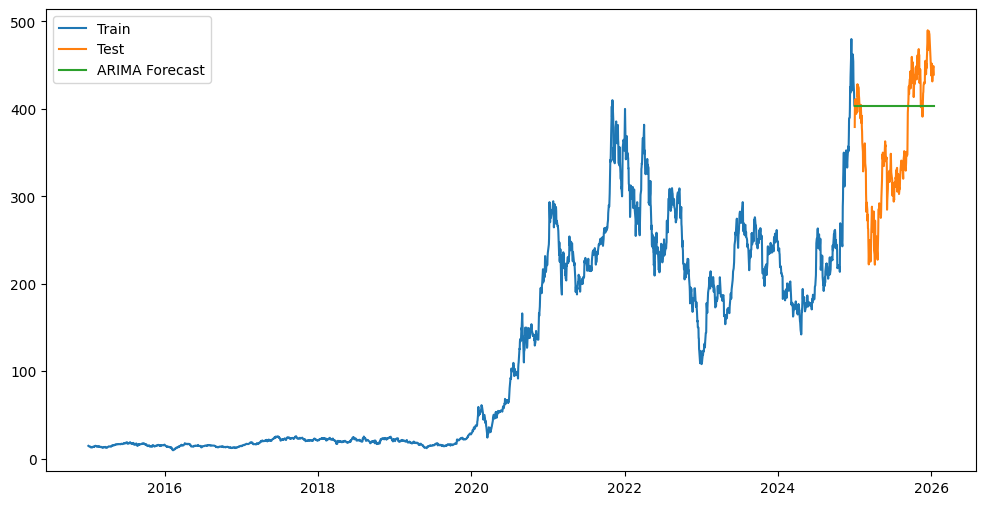

In [4]:
# Train with best params
order = auto_model.order
print(f"Training ARIMA with order {order}...")
arima_model_fit = train_arima_model(train_data, order=order)

# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test_data))
arima_forecast.index = test_data.index

# Evaluate
arima_metrics = evaluate_model_metrics(test_data, arima_forecast)
print("ARIMA Metrics:", arima_metrics)

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

## 3. Implement LSTM Model

In [5]:
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_prices.values.reshape(-1, 1))

# Define look_back
look_back = 60

# Prepare Sequences
# Note: We need to be careful with splitting scaled data to match train/test dates correctly
train_size = len(train_data)
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size - look_back:] # Include lookback for first test prediction

X_train, y_train = prepare_lstm_data(train_scaled, look_back)
X_test, y_test = prepare_lstm_data(test_scaled, look_back)

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (2456, 60, 1)
X_test shape: (259, 60, 1)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0060
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0010
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.7983e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.2907e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.6147e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.4468e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.6070e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.5678e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.7930e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.5527e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.0371e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.8940e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.7716e-04
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.4411e-04
Epoch 15/20
77/77 ━━━━━

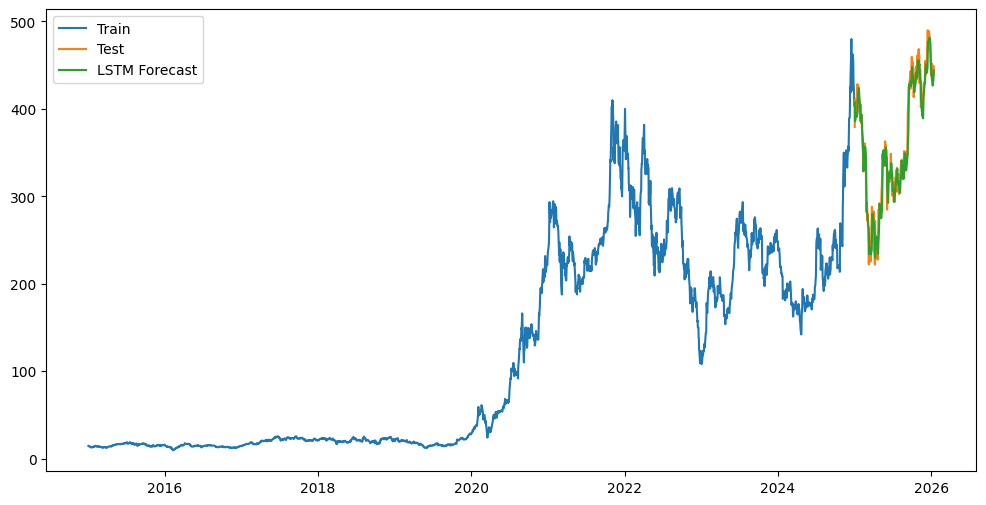

In [6]:
# Build and Train LSTM
lstm_model = build_lstm_model((X_train.shape[1], 1))
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Evaluate
# Align indices for metrics
lstm_metrics = evaluate_model_metrics(test_data.values, lstm_predictions.flatten())
print("LSTM Metrics:", lstm_metrics)

# Plot
plot_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index)

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(plot_predictions, label='LSTM Forecast')
plt.legend()
plt.show()

## 4. Model Comparison

             MAE       RMSE       MAPE
ARIMA  69.498957  82.934613  22.557915
LSTM   11.678238  14.965024   3.431253


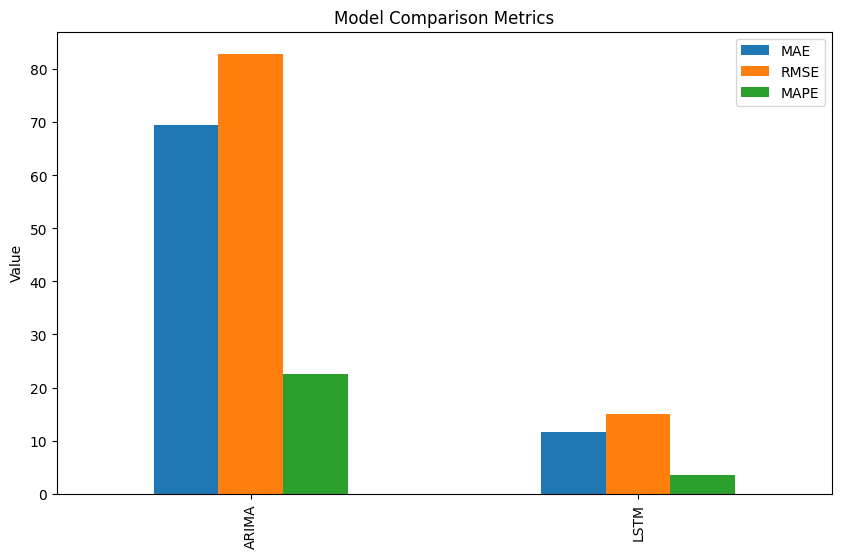

In [7]:
comparison_df = pd.DataFrame([arima_metrics, lstm_metrics], index=['ARIMA', 'LSTM'])
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison Metrics")
plt.ylabel("Value")
plt.show()